# Вариационный автокодировщик

В задании предлагается реализовать вариационный и обычный автокодировщики, обучить их на MNIST, сравнить между собой эти модели, сделать выводы по результатам сравнения и выводы про каждую модель по отдельности.

Необходимая теория приведена ниже. Для более глубокого погружения в тему также есть список литературы с комментариями.

В этом задании нельзя использовать функций плотностей распределений, KL-дивергенцию и репараметризации из стандартных библиотек.

## Теория

### Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

### Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. Сэмплируем $x \sim p_\theta(x | z)$.

Параметры распределения $p_\theta(x | z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$. Эта сеть называется генеративной сетью (generator) или декодером (decoder).

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z)$$

### Параметризация модели
Априорное распределение на скрытые перменные - стандартное нормальное распределение: $p(z) = \mathcal{N}(z | 0, I)$.

Распределения на компоненты $x$ условно независимы относительно $z$: $p_\theta(x | z) = \prod\limits_{i = 1}^D p_\theta(x_i | z)$.

Если i-ый признак объекта вещественный, то $p_\theta(x_i | z) = \mathcal{N}(x_i | \mu_i(z, \theta), \sigma^2_i(z, \theta))$.
Здесь $\mu(z, \theta)$ и $\sigma(z, \theta)$ - детерминированные функции, задаваемые нейросетями с параметрами $\theta$.

Если i-ый признак категориальный, то $p_\theta(x_i | z) = Cat(Softmax(\omega_i(z, \theta)))$, где $\omega_i(z, \theta)$ - тоже детерминированная функция задаваемая нейросетью.

Отдельно можно рассмотреть бинарные признаки, для которых категориальное распределение превращается в распределение Бернулли с одним параметром.

Подсказка: некоторые пиксели черные во всей обучающей выборке MNIST, поэтому максимизация правдоподибия будет заставлять модель уводить на бесконечность веса, соответствующие этим пикселям.
Чтобы избежать расходимости весов модели, можно переопределить модель таким образом, что для любой активации пикселя менее $\varepsilon$ или более $1 - \varepsilon$ она выдает вероятность этого пикселя равную $\varepsilon$ или $1 - \varepsilon$ соответственно.

### Вариационная нижняя оценка логарифма правдоподобия

Для максимизации правдоподобия максимизируем вариационную нижнюю оценку на логарифм правдоподобия:
$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x) = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z) q_\phi(z | x)}{q_\phi(z | x) p_\theta(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z)}{q_\phi(z | x)} + KL(q_\phi(z | x) || p_\theta(z | x))$$
$$\log p_\theta(x) \geqslant \mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x | z)p(z)}{q_\phi(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z) - KL(q_\phi(z | x) || p(z)) = L(x; \phi, \theta)
\to \max\limits_{\phi, \theta}$$

$q_\phi(z | x)$ называется предложным (proposal), распознающим (recognition) или вариационным (variational) распределением. Это гауссиана, чьи параметры задаются нейросетью с весами $\phi$:
$q_\phi(z | x) = \mathcal{N}(z | \mu_\phi(x), \sigma^2_\phi(x)I)$.
Обычно нейросеть моделирует не $\sigma_\phi(x)$, а $\log\sigma_\phi(x)$ или $\log(\exp(\sigma_\phi(x) - 1))$ или другую величину, более инвариантную к масштабу и определенную на всех вещественных числах так, чтобы $\sigma_\phi(x)$ было всегда положительным. В этом задании нужно использовать $\log(\exp(\sigma_\phi(x) - 1))$, поскольку обратное к нему преобразование softplus более стабильно, чем экспонента.

Зазор между вариационной нижней оценкой $L(x; \phi, \theta)$ на логарифм правдоподобия модели и самим логарифмом правдоподобия $\log p_\theta(x)$ - это KL-дивергенция между предолжным и апостериорным распределением на $z$: $KL(q_\phi(z | x) || p_\theta(z | x))$. Максимальное значение $L(x; \phi, \theta)$ при фиксированных параметрах модели $\theta$ достигается при $q_\phi(z | x) = p_\theta(z | x)$, но явное вычисление $p_\theta(z | x)$ требует слишком большого числа ресурсов, поэтому вместо этого вычисления вариационная нижняя оценка оптимизируется также по $\phi$. Чем ближе $q_\phi(z | x)$ к $p_\theta(z | x)$, тем точнее вариационная нижняя оценка.
Истинное апостериорное распределение $p_\theta(z | x)$ часто не может быть представлено одной гауссианой, поэтому зазор между нижней оценкой и логарифмом правдоподобия не достигает $0$. Тем не менее, есть статьи, утверждающие, что этот зазор практически не влияет на процесс оптимизации модели и его результат по сравнению с другими факторами (см. литературу).

Первое слагаемое вариационной нижней оценки $\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z)$ называется ошибкой восстановления (reconstruction loss).
Модель, соответствующая этой части - это автокодирощик с одним стохастическим слоем, пытающийся восстановить входной объект $x$.
Если распределение $q_\phi(z | x)$ - дельта-функция, то автокодировщик со стохастическим слоем превращается в обычный автокодировщик.
Поэтому $q_\phi(z | x)$ и $p_\theta(x | z)$ иногда называют энкодером и декодером соответственно.

Слагаемое $KL(q_\phi(z | x) || p(z))$ иногда называют регуляризатором.
Оно вынуждает $z \sim q_\phi(z | x)$ быть близким к $0$ и $q_\phi(z | x)$ быть близким к $p_\theta(z | x)$.
Иногда коэффициент при KL-дивергенции полагают не равным единице или даже используют другой регуляризатор.
Естественно, после этого обучение модели перестает соответствовать максимизации правдоподобия вышеописанной вероятностной модели данных.
Это существенно снижает интерпретируемость модели, устраняет теоретические гарантии для неё.
KL-дивергенция между двумя нормальными распределениями может быть вычислена аналитически.

Для максимизации $L(x; \phi, \theta)$ используется стохастический градиентный подъем.
Градиент ошибки восстановления по $\theta$ вычисляется с помощью метода обратного распространения ошибки.
$$\frac{\partial}{\partial \theta} L(x; \phi, \theta) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{\partial}{\partial \theta} \log p_\theta(x | z)$$

Градиент KL-дивергенции по $\phi$ может быть вычислен аналитически.
Для вычисления градиента ошибки восстановления по $\phi$ используется репараметризация (reparametrization trick):
$$\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)$$
$$z = \mu + \sigma \varepsilon \Rightarrow z \sim \mathcal{N}(z | \mu, \sigma^2I)$$
$$\frac{\partial}{\partial \phi} L(x; \phi, \theta) = \mathbb{E}_{\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)} \frac{\partial}{\partial \phi} \log p_\theta(x | \mu_\phi(x) + \sigma_\phi(x) \varepsilon) - \frac{\partial}{\partial \phi} KL(q_\phi(z | x) || p(z))$$

Подсказка: для выведения аналиической формулы KL-дивергенции между нормальными распределениями главное - никогда не писать знак интеграла. В задании рассматриваются только нормальные распределения с диагональной матрицей ковариации, поэтому достаточно вывести KL-дивергенцию между двумя одномерными нормальными распределениями. Все, что требуется для выведения формулы:
$$KL(q || p) = \mathbb{E}_{z \sim q} \log\frac{q(z)}{p(z)}$$
$$\log \mathrm{N}(z | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left(-\frac{(z - \mu)^2}{2\sigma^2} \right)$$
$$\mathbb{E}_{z \sim N(\mu, \sigma)}z = \mu$$
$$\mathbb{E}_{z \sim N(\mu, \sigma)}z^2 = \mu^2 + \sigma ^ 2$$
Кстати, у трех последних формул есть часто используемые многомерные обощения.

### Оценка правдоподобия модели

Правдоподобие модели $p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z)$ оценивают на отложенной выборке.

Оценка может быть получена с помощью метода Монте-Карло:

$$z_i \sim p(z), i = 1, \dots, K$$
$$p_\theta(x) \approx \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(x | z_i)$$

Альтернативный способ оценки - метод importance sampling. В качестве предложного распределения метода используется предложное распределение модели. Известно, что хороший выбор предложного распределения уменьшает дисперсию оценки. Для вариационных автокодировщиков оценки Монте-Карло, основанные на малом числе сэмплов, обычно занижены. Поэтому imporatance sampling также позволяет получить более высокую и точную оценку правдоподобия с помощью меньшего числа сэмплов.

$$z_i \sim q_\phi(z | x), i = 1, \dots, K$$
$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{p_\theta(x | z) p(z)}{q_\phi(z | x)} \approx \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)}$$

Для оценки логарифма правдоподобия усреднение вероятностей происходит под логарифмом:
$$\log p_\theta(x) \approx \log \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(x | z_i),\,\,\,\,z_i \sim p(z)$$
$$\log p_\theta(x) \approx \log \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)},\,\,\,\,z_i \sim q_\phi(z | x)$$
Заметим, что оценки логарифма правдоподобия уже не являются несмещенными, в отличие от оценок самого правдоподобия.
Несмотря на это, первую оценку все равно обычно называют оценкой Монте-Карло логарифма правдоподобия.
Вторая оценка известна в литературе как IWAE оценка по названию модели Importance Weighted Variational Autoencoders, в которой предлагается напрямую оптимизировать эту оценку правдоподобия для обучения автокодировщика.

### Литература
1. Auto-Encoding Variational Bayes https://arxiv.org/pdf/1312.6114.pdf, Stochastic Backpropagation and Approximate Inference in Deep Generative Models https://arxiv.org/pdf/1401.4082.pdf - оригинальные статьи про вариационный автокодировщик (две группы авторов независимо и почти одновременно предложили одинаковые модели).
2. Learning Structured Output Representation using Deep Conditional Generative Models https://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf - обусловленный вариационный автокодировщик для генерации из обусловленного распределения на объекты.
3. Importance Weighted Autoencoders https://arxiv.org/pdf/1509.00519.pdf - вариационный автокодировщик, оптимизирующий более точную нижнюю оценку на логарифм правдоподобия.
4. Tighter Variational Bounds are Not Necessarily Better https://arxiv.org/pdf/1802.04537.pdf - статья, показывающая, что предыдущая статья ухудшает обучение предложной сети автокодировщика как следствие более хорошей нижней оценки, и предлагающая способы решения этой проблемы.
5. Variational Inference with Normalizing Flows https://arxiv.org/pdf/1505.05770.pdf, Improved Variational Inference with Inverse Autoregressive Flow http://papers.nips.cc/paper/6581-improved-variational-inference-with-inverse-autoregressive-flow.pdf - более богатые семейства предложных распредлений.
6. VAE with a VampPrior https://arxiv.org/pdf/1705.07120.pdf - обучение априорного распределения на скрытые представления совместно с предложным. Улучшает правдоподобие модели, но делает менее интерпретируемым скрытое пространство.
7. Ladder Variation Autoencoders http://papers.nips.cc/paper/6275-ladder-variational-autoencoders.pdf - теперь у каждого объекта есть не одно скрытое представление, а несколько организованных в иерархию.
8. Inference Suboptimality in Variational Autoencoders https://arxiv.org/pdf/1801.03558.pdf - утверждает, что отличие предложного распределения от истинного апостериорного распределения в скрытом пространстве вызваны недостаточной выразительностью предложной сети, а не бедным семейством предложных распределений. Богатое же семейство предложных моделей снижает требования к выразительности предложной сети.

## Практика

### Загрузка, предобработка и визуалиация данных

In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim

In [2]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

/home/alex/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/alex/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/alex/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/alex/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


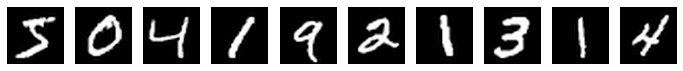

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 28, 28)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

Для корректности вероятностной модели исходное изображение также должно быть бинаризовано.

Бинаризация может производиться как округлением данных в датасете, так и сэмплированием из распределения Бернулли каждого пикселя. Округление приводит к более гладким фигурам в обучающей выборке, поэтому будем использовать его.

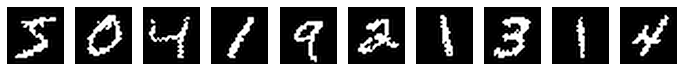

In [4]:
show_images(torch.bernoulli(train_data[:10][0]))

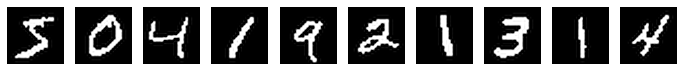

In [5]:
show_images(train_data[:10][0].round())

In [6]:
train_data.tensors = (train_data.tensors[0].round(), train_data.tensors[1])
test_data.tensors = (test_data.tensors[0].round(), test_data.tensors[1])

### Вспомогательные функции для обучения и тестирования

In [7]:
def model_test_loss(compute_loss, batch_size=100, max_batches=None, verbose=False):
    """
    Функция вычисляет усредненное значение функции потерь по тестовым данным.
    Вход: compute_loss, функция, принимающая батч в виде матрицы torch.FloatTensor
    и возвращающая float - функцию потерь на батче.
    Вход: batch_size, int.
    Вход: max_batches, int - если задано, включает режим оценки функции потерь
    с помощью сэмплирования батчей вместо полного прохода по данным и указывает,
    после какого батча прекратить вычисления.
    Вход: verbose, bool - указывает, печатать ли текущее состояние в процессе работы.
    Возвращаемое значение: float - оценка функции потерь на тестовых данных.
    """
    dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=(max_batches is None))
    num_batches = len(dataloader)
    avg_loss = 0
    for i, (batch, _) in enumerate(dataloader):
        loss = compute_loss(batch)
        avg_loss += (loss - avg_loss) / (i + 1)
        if verbose and (i + 1) % 10 == 0:
            print('\rTest loss:', avg_loss,
                  'Batch', i + 1, 'of', num_batches, ' ' * 10, end='', flush=True)
        if verbose and (i + 1) % 100 == 0:
            print(flush=True)
        if max_batches and i >= max_batches:
            break
    return avg_loss

In [8]:
def train_model(model, tests=[], batch_size=100, num_epochs=5, learning_rate=1e-3, maximization=True):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: tests - список тестов, выполняемых после каждого 100-го батча.
    Каждый элемент списка - словарь с полями 'name' - уникальным идентификатором
    теста и 'func' - функцией от модели.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'train_losses_list' - список функций потерь на каждом батче и 
    'test_results' - список результатов тестирования. Каждый результат
    тестирования - словарь вида name: value, где name - имя теста,
    value - результат его выполнения.
    """
    gd = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(dataloader):
            total = len(dataloader)
            loss = model.batch_loss(batch)
            if maximization:
                (-loss).backward()
            else:
                loss.backward()
            train_losses.append(float(loss))
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            if (i + 1) % 100 == 0:
                cur_test_result = {}
                for test in tests:
                    cur_test_result[test['name']] = test['func'](model)
                test_results.append(cur_test_result)
                print(flush=True)
            gd.step()
            gd.zero_grad()
    return {
        'model': model,
        'train_losses_list': train_losses,
        'test_results': test_results
    }

In [9]:
n = 15
digit_size = 28

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

In [10]:
def draw_latent_space(data, target, encoder):
    z_test = encoder(data)
    plt.figure(figsize=(7, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=target, cmap='gist_rainbow', alpha=0.75)
    plt.colorbar()
    plt.show()

In [11]:
from sklearn.manifold import TSNE

## Обычный автокодировщик

In [12]:
from models import AE

### Обучение моделей

In [13]:
ae_tests = [
    {
        'name': 'test_loss',
        'func': lambda model:
                model_test_loss(lambda batch:
                                float(model.batch_loss(batch)),
                                max_batches=20)
    }
]

In [14]:
ae_model_d2 = train_model(AE(2, 784), tests=ae_tests, maximization=False, num_epochs=50)

Train loss: 62.5234375 Batch 100 of 600                  
Train loss: 58.5167121887207 Batch 200 of 600             
Train loss: 57.08954620361328 Batch 300 of 600            
Train loss: 59.568824768066406 Batch 400 of 600           
Train loss: 53.584686279296875 Batch 500 of 600           
Train loss: 56.166053771972656 Batch 600 of 600           
Train loss: 56.3399772644043 Batch 100 of 600            
Train loss: 50.405296325683594 Batch 200 of 600           
Train loss: 53.42634201049805 Batch 300 of 600            
Train loss: 55.52193832397461 Batch 400 of 600            
Train loss: 53.18544387817383 Batch 500 of 600            
Train loss: 55.34794998168945 Batch 600 of 600            
Train loss: 53.94379425048828 Batch 100 of 600           
Train loss: 54.973880767822266 Batch 200 of 600           
Train loss: 50.556087493896484 Batch 300 of 600           
Train loss: 51.475460052490234 Batch 400 of 600           
Train loss: 55.433128356933594 Batch 500 of 600           


Train loss: 44.698875427246094 Batch 200 of 600           
Train loss: 42.66861343383789 Batch 300 of 600            
Train loss: 44.73408508300781 Batch 400 of 600            
Train loss: 49.14195251464844 Batch 500 of 600            
Train loss: 44.64459991455078 Batch 600 of 600            
Train loss: 45.25632858276367 Batch 100 of 600           
Train loss: 45.34788131713867 Batch 200 of 600            
Train loss: 46.28461837768555 Batch 300 of 600            
Train loss: 46.10566329956055 Batch 400 of 600            
Train loss: 45.823760986328125 Batch 500 of 600           
Train loss: 41.88243103027344 Batch 600 of 600            
Train loss: 45.109161376953125 Batch 100 of 600           
Train loss: 47.18818283081055 Batch 200 of 600            
Train loss: 45.24290084838867 Batch 300 of 600            
Train loss: 44.07795715332031 Batch 400 of 600            
Train loss: 46.04048156738281 Batch 500 of 600            
Train loss: 45.95262145996094 Batch 600 of 600           

Train loss: 45.9599723815918 Batch 300 of 600             
Train loss: 45.594322204589844 Batch 400 of 600           
Train loss: 46.371826171875 Batch 500 of 600              
Train loss: 46.68301773071289 Batch 600 of 600            
Train loss: 45.509464263916016 Batch 100 of 600           
Train loss: 43.68669128417969 Batch 200 of 600            
Train loss: 45.663394927978516 Batch 300 of 600           
Train loss: 47.50849533081055 Batch 400 of 600            
Train loss: 44.54291534423828 Batch 500 of 600            
Train loss: 44.33449172973633 Batch 600 of 600            
Train loss: 44.063140869140625 Batch 100 of 600           
Train loss: 44.684932708740234 Batch 200 of 600           
Train loss: 42.62887191772461 Batch 300 of 600            
Train loss: 48.400569915771484 Batch 400 of 600           
Train loss: 44.464500427246094 Batch 500 of 600           
Train loss: 45.905818939208984 Batch 600 of 600           
Train loss: 46.03691101074219 Batch 100 of 600          

In [15]:
ae_model_d10 = train_model(AE(10, 784), tests=ae_tests, maximization=False, num_epochs=50)

Train loss: 60.61677169799805 Batch 100 of 600           
Train loss: 47.20649719238281 Batch 200 of 600            
Train loss: 40.93434524536133 Batch 300 of 600            
Train loss: 35.05790328979492 Batch 400 of 600            
Train loss: 39.172767639160156 Batch 500 of 600           
Train loss: 36.666996002197266 Batch 600 of 600           
Train loss: 32.951637268066406 Batch 100 of 600           
Train loss: 33.03285598754883 Batch 200 of 600            
Train loss: 33.161468505859375 Batch 300 of 600           
Train loss: 31.220970153808594 Batch 400 of 600           
Train loss: 32.615264892578125 Batch 500 of 600           
Train loss: 32.9411506652832 Batch 600 of 600             
Train loss: 30.76660919189453 Batch 100 of 600           
Train loss: 31.479721069335938 Batch 200 of 600           
Train loss: 30.941904067993164 Batch 300 of 600           
Train loss: 31.586952209472656 Batch 400 of 600           
Train loss: 31.248258590698242 Batch 500 of 600           

Train loss: 22.316604614257812 Batch 200 of 600           
Train loss: 21.597780227661133 Batch 300 of 600           
Train loss: 23.0853271484375 Batch 400 of 600             
Train loss: 23.595739364624023 Batch 500 of 600           
Train loss: 23.961170196533203 Batch 600 of 600           
Train loss: 22.992698669433594 Batch 100 of 600           
Train loss: 23.299968719482422 Batch 200 of 600           
Train loss: 22.157880783081055 Batch 300 of 600           
Train loss: 23.913949966430664 Batch 400 of 600           
Train loss: 24.023658752441406 Batch 500 of 600           
Train loss: 23.803789138793945 Batch 600 of 600           
Train loss: 23.42461585998535 Batch 100 of 600           
Train loss: 24.51085662841797 Batch 200 of 600            
Train loss: 22.504138946533203 Batch 300 of 600           
Train loss: 21.682401657104492 Batch 400 of 600           
Train loss: 22.831281661987305 Batch 500 of 600           
Train loss: 23.50656509399414 Batch 600 of 600           

Train loss: 21.502517700195312 Batch 200 of 600           
Train loss: 20.67188262939453 Batch 300 of 600            
Train loss: 21.37023162841797 Batch 400 of 600            
Train loss: 20.866039276123047 Batch 500 of 600           
Train loss: 21.849069595336914 Batch 600 of 600           
Train loss: 22.183916091918945 Batch 100 of 600           
Train loss: 21.070117950439453 Batch 200 of 600           
Train loss: 19.137039184570312 Batch 300 of 600           
Train loss: 21.626436233520508 Batch 400 of 600           
Train loss: 21.74260902404785 Batch 500 of 600            
Train loss: 22.407434463500977 Batch 600 of 600           
Train loss: 21.7200927734375 Batch 100 of 600            
Train loss: 21.63231658935547 Batch 200 of 600            
Train loss: 22.859437942504883 Batch 300 of 600           
Train loss: 21.806568145751953 Batch 400 of 600           
Train loss: 21.527631759643555 Batch 500 of 600           
Train loss: 19.754091262817383 Batch 600 of 600          

### Оценка качества моделей
Визуальная оценка генерируемых объектов

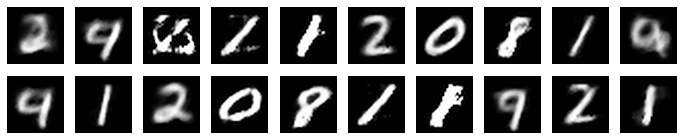

In [16]:
show_images(ae_model_d2['model'].generate_samples(20))

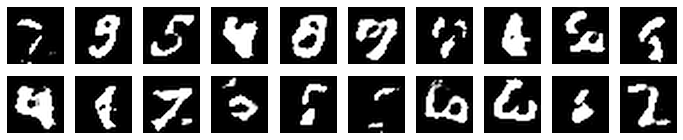

In [17]:
show_images(ae_model_d10['model'].generate_samples(20))

Визуализация латентного пространства (с точки зрения декодера)

In [18]:
def draw_manifold_ae(model):
    generator = lambda z: model.decode(torch.from_numpy(z).float()).view(28, 28).data.numpy()
    return draw_manifold(generator)

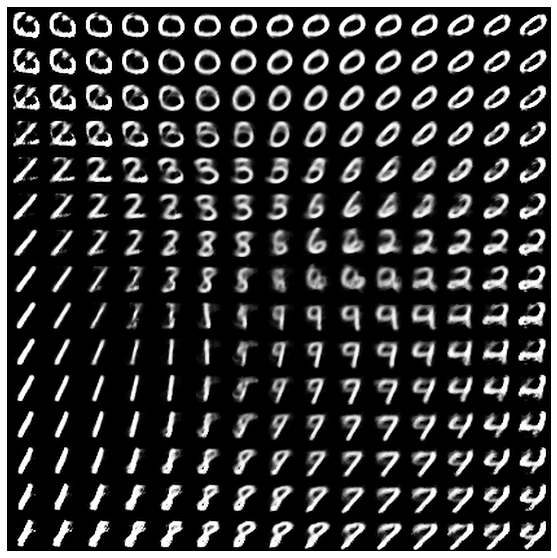

In [19]:
draw_manifold_ae(ae_model_d2['model'])

Визуализация латентного пространства (с точки зрения энкодера)

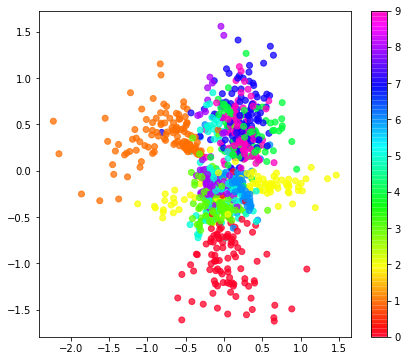

In [20]:
draw_latent_space(test_data.tensors[0][::10], test_data.tensors[1][::10],
                  lambda data: ae_model_d2['model'].encode(data).detach())

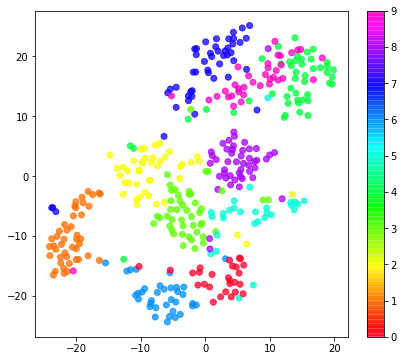

In [21]:
ae_encoder_d10 = lambda data: TSNE().fit_transform(ae_model_d10['model'].encode(data).data.numpy())
draw_latent_space(test_data.tensors[0][::25], test_data.tensors[1][::25], ae_encoder_d10)

## Автокодировщик: теперь вариационный!

В качестве функции потерь используем бинарную кроссэнтропию.
Это означает, что мы предполагаем, что каждый пискель - бинарная случайная величина.
Генеративная сеть выдает вероятность каждого пикселя быть равным $1$.

In [22]:
from models import log_likelihood, log_mean_exp, kl

In [23]:
from models import VAE

### Оценки функции потерь

In [24]:
from models import gaussian_log_pdf, compute_log_likelihood_monte_carlo, compute_log_likelihood_iwae

### Обучение модели

In [25]:
vae_tests = [
    {
        'name': 'MC',
        'func': lambda model:
                model_test_loss(lambda batch:
                                compute_log_likelihood_monte_carlo(batch, model, K=10),
                                max_batches=20)
    },
    {
        'name': 'IS',
        'func': lambda model:
                model_test_loss(lambda batch:
                                compute_log_likelihood_iwae(batch, model, K=10),
                                max_batches=20)
    }
]

In [26]:
vae_model_d2 = train_model(VAE(2, 784), tests=vae_tests, num_epochs=50)

Train loss: -196.82046508789062 Batch 100 of 600           
Train loss: -193.6619110107422 Batch 200 of 600            
Train loss: -175.837158203125 Batch 300 of 600             
Train loss: -171.98619079589844 Batch 400 of 600           
Train loss: -172.91561889648438 Batch 500 of 600           
Train loss: -179.77291870117188 Batch 600 of 600           
Train loss: -158.30186462402344 Batch 100 of 600           
Train loss: -166.58094787597656 Batch 200 of 600           
Train loss: -164.70770263671875 Batch 300 of 600           
Train loss: -168.72579956054688 Batch 400 of 600           
Train loss: -162.08290100097656 Batch 500 of 600           
Train loss: -169.69786071777344 Batch 600 of 600           
Train loss: -161.89291381835938 Batch 100 of 600           
Train loss: -164.70045471191406 Batch 200 of 600           
Train loss: -156.8648681640625 Batch 300 of 600            
Train loss: -159.00869750976562 Batch 400 of 600           
Train loss: -155.885986328125 Batch 500 

Train loss: -138.77586364746094 Batch 500 of 600           
Train loss: -147.56204223632812 Batch 600 of 600           
Train loss: -152.49343872070312 Batch 100 of 600           
Train loss: -150.31378173828125 Batch 200 of 600           -148.11241149902344 Batch 170 of 600           
Train loss: -146.1645050048828 Batch 300 of 600            
Train loss: -153.66957092285156 Batch 400 of 600           
Train loss: -145.03623962402344 Batch 500 of 600           
Train loss: -151.76483154296875 Batch 600 of 600           
Train loss: -152.5886688232422 Batch 100 of 600           
Train loss: -139.85484313964844 Batch 200 of 600           
Train loss: -148.58294677734375 Batch 300 of 600           
Train loss: -151.33880615234375 Batch 400 of 600           
Train loss: -150.2604217529297 Batch 500 of 600            
Train loss: -155.50234985351562 Batch 600 of 600           
Train loss: -140.6070098876953 Batch 100 of 600           
Train loss: -151.21847534179688 Batch 200 of 600       

Train loss: -140.7147674560547 Batch 100 of 600           
Train loss: -135.65936279296875 Batch 200 of 600           
Train loss: -143.09820556640625 Batch 300 of 600           
Train loss: -147.6148681640625 Batch 400 of 600            
Train loss: -137.0626983642578 Batch 500 of 600            
Train loss: -144.89022827148438 Batch 600 of 600           
Train loss: -150.51699829101562 Batch 100 of 600           
Train loss: -143.2317657470703 Batch 200 of 600            
Train loss: -151.09072875976562 Batch 300 of 600           
Train loss: -150.74021911621094 Batch 400 of 600           
Train loss: -147.76406860351562 Batch 500 of 600           
Train loss: -155.4907989501953 Batch 600 of 600            
Train loss: -152.90110778808594 Batch 100 of 600           
Train loss: -140.36770629882812 Batch 200 of 600           
Train loss: -143.86431884765625 Batch 300 of 600           
Train loss: -143.35638427734375 Batch 400 of 600           
Train loss: -140.61903381347656 Batch 500

In [27]:
vae_model_d10 = train_model(VAE(10, 784), tests=vae_tests, num_epochs=50)

Train loss: -193.29086303710938 Batch 100 of 600           
Train loss: -160.10740661621094 Batch 200 of 600           
Train loss: -144.3520050048828 Batch 300 of 600            
Train loss: -139.61703491210938 Batch 400 of 600           
Train loss: -136.50563049316406 Batch 500 of 600           
Train loss: -124.87107849121094 Batch 600 of 600           
Train loss: -120.2656021118164 Batch 100 of 600           
Train loss: -128.60153198242188 Batch 200 of 600           
Train loss: -126.15364074707031 Batch 300 of 600           
Train loss: -113.45767211914062 Batch 400 of 600           
Train loss: -116.12542724609375 Batch 500 of 600           
Train loss: -111.49673461914062 Batch 600 of 600           
Train loss: -110.82064056396484 Batch 100 of 600           
Train loss: -116.55427551269531 Batch 200 of 600           
Train loss: -115.7228775024414 Batch 300 of 600            
Train loss: -110.01008605957031 Batch 400 of 600           
Train loss: -118.28107452392578 Batch 500

Train loss: -94.75501251220703 Batch 500 of 600            
Train loss: -94.8921127319336 Batch 600 of 600             
Train loss: -95.38253021240234 Batch 100 of 600           
Train loss: -102.26582336425781 Batch 200 of 600           
Train loss: -98.17068481445312 Batch 300 of 600           
Train loss: -93.05536651611328 Batch 400 of 600            
Train loss: -97.54022216796875 Batch 500 of 600            
Train loss: -98.76071166992188 Batch 600 of 600            
Train loss: -101.7551040649414 Batch 100 of 600           
Train loss: -91.16194915771484 Batch 200 of 600           
Train loss: -95.2143783569336 Batch 300 of 600             
Train loss: -96.50834655761719 Batch 400 of 600           
Train loss: -94.26024627685547 Batch 500 of 600           
Train loss: -95.2903823852539 Batch 600 of 600             
Train loss: -96.65301513671875 Batch 100 of 600           
Train loss: -95.64488220214844 Batch 200 of 600            
Train loss: -97.85340881347656 Batch 300 of 600

Train loss: -93.10598754882812 Batch 300 of 600           
Train loss: -88.6384506225586 Batch 400 of 600            
Train loss: -96.29617309570312 Batch 500 of 600           
Train loss: -96.35445404052734 Batch 600 of 600           
Train loss: -90.7166748046875 Batch 100 of 600            
Train loss: -91.04251098632812 Batch 200 of 600           
Train loss: -89.50067901611328 Batch 300 of 600           
Train loss: -98.24974822998047 Batch 400 of 600            
Train loss: -94.08534240722656 Batch 500 of 600            
Train loss: -94.59838104248047 Batch 600 of 600            
Train loss: -98.3401870727539 Batch 100 of 600           
Train loss: -93.15826416015625 Batch 200 of 600            
Train loss: -90.45513916015625 Batch 300 of 600            
Train loss: -92.79312896728516 Batch 400 of 600           
Train loss: -88.53977966308594 Batch 500 of 600            
Train loss: -90.59497833251953 Batch 600 of 600           
Train loss: -95.85652160644531 Batch 100 of 600    

### Оценка качества модели

Визуальная оценка генерируемых объектов

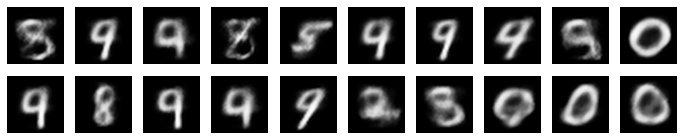

In [28]:
show_images(vae_model_d2['model'].generate_samples(20))

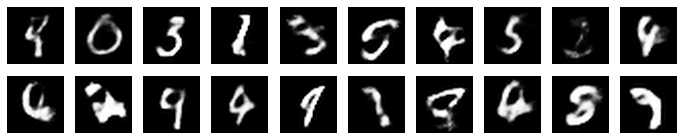

In [29]:
show_images(vae_model_d10['model'].generate_samples(20))

Визуализация латентного пространства (с точки зрения декодера)

In [30]:
def draw_manifold_vae(model):
    generator = lambda z: model.generative_distr(torch.from_numpy(z).unsqueeze(1).float()).view(28, 28).data.numpy()
    return draw_manifold(generator)

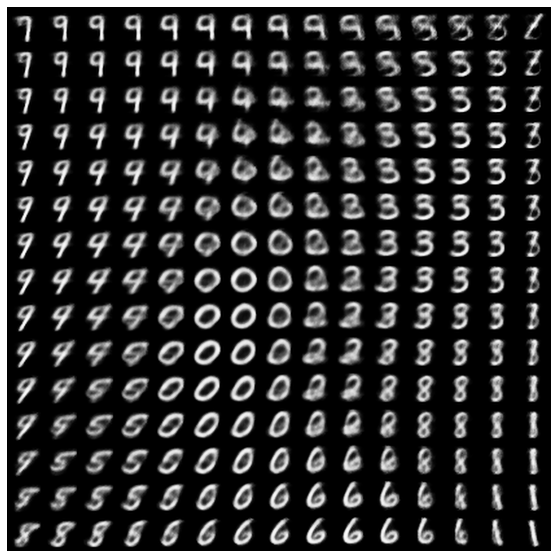

In [31]:
draw_manifold_vae(vae_model_d2['model'])

Визуализация латетного пространства (с точки зрения энкодера)

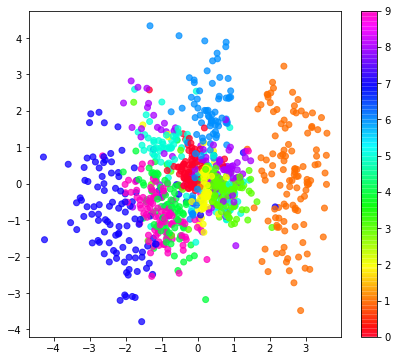

In [32]:
vae_encoder = lambda data, model: model.sample_latent(model.proposal_distr(data))[:, 0].detach()
draw_latent_space(test_data.tensors[0][::10], test_data.tensors[1][::10],
                  lambda data: vae_encoder(data, vae_model_d2['model']))

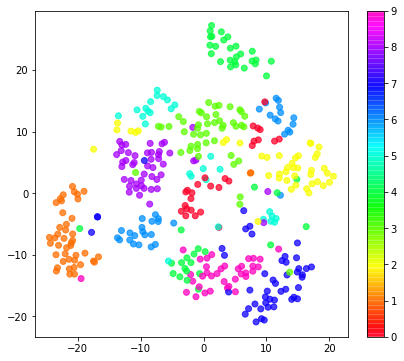

In [33]:
vae_encoder_d10 = lambda data: TSNE().fit_transform(vae_encoder(data, vae_model_d10['model']).data.numpy())
draw_latent_space(test_data.tensors[0][::25], test_data.tensors[1][::25], vae_encoder_d10)

### Оценки логарифма правдоподобия на тестовых данных

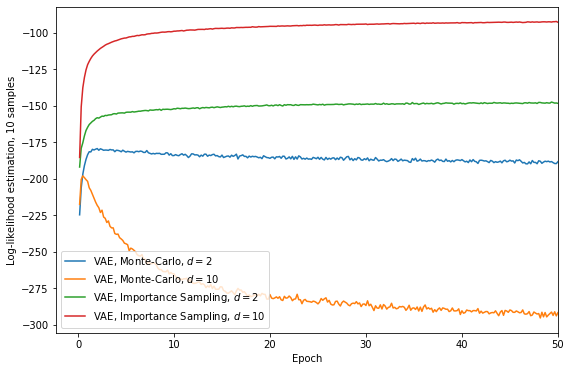

In [34]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('VAE, Monte-Carlo, $d = 2$', 'MC', vae_model_d2),
    ('VAE, Monte-Carlo, $d = 10$', 'MC', vae_model_d10),
    ('VAE, Importance Sampling, $d = 2$', 'IS', vae_model_d2),
    ('VAE, Importance Sampling, $d = 10$', 'IS', vae_model_d10),
]:
    data = [x[name] for x in model['test_results']]
    x_labels = (1 + np.arange(len(data))) / 6
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation, 10 samples')
plt.legend()
pass

In [35]:
test_results = []
for K in [1, 5, 10, 50, 100, 500, 1000]:
    print('K =', K, flush=True)
    vae_tests_sampling = [
        {
            'name': 'D10MC',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_monte_carlo(batch, vae_model_d10['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        },
        {
            'name': 'D10IWAE',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_iwae(batch, vae_model_d10['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        },
        {
            'name': 'D2MC',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_monte_carlo(batch, vae_model_d2['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        },
        {
            'name': 'D2IWAE',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_iwae(batch, vae_model_d2['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        }
    ]
    cur_test_results = {'K': K}
    for test in vae_tests_sampling:
        cur_test_results[test['name']] = test['func']
    test_results.append(cur_test_results)

K = 1
K = 5
K = 10
K = 50
K = 100
K = 500
K = 1000


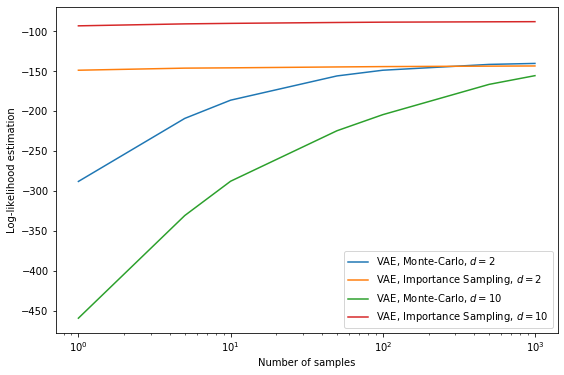

In [36]:
plt.figure(figsize=(9, 6))
for label, name in [
    ('VAE, Monte-Carlo, $d = 2$', 'D2MC'),
    ('VAE, Importance Sampling, $d = 2$', 'D2IWAE'),
    ('VAE, Monte-Carlo, $d = 10$', 'D10MC'),
    ('VAE, Importance Sampling, $d = 10$', 'D10IWAE'),
]:
    data = [x[name] for x in test_results]
    x_labels = [x['K'] for x in test_results]
    plt.plot(x_labels, data, label=label)
plt.xlabel('Number of samples')
plt.xscale('log')
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы

Место для ваших выводов, наблюдений, гипотез.

1) изображения, полученные с $d = 2$, заметно более расплывчатые, с $d = 10$ - более четкие ($d$ - размерность латентного пространства), модель лучше передает контуры, более "уверенна" в предсказании;

2) IWAE оценка на тестовых данных увеличивается все время обучения модели, оценка Монте-Карло быстро начинает снижаться и особенно сильно снижается при $d = 10$ (при большей размерности латентного пространства); судя графику зависимости оценки логарифма правдоподобия от числа сэмплов, оценка Монте-Карло при большем $d$ может приблизиться к ней же при меньшем $d$, но для этого необходимо использовать гораздо больше сэмплов;

3) IWAE оценка показывает большее значение при большем $d$, в отличие от оценки Монте-Карло, и, в целом, кажется более адекватной, также она существенно более независима от числа сэмплов;

4) по сравнению с AE, VAE в данном эксперименте лучше сохраняет примерную толщину линий;

5) возможно, замена L2-ошибки на кросс-энтропию при обучении AE могла бы изменить его результаты